In [1]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
from IPython.display import display, HTML
from IPython.core.display import display, HTML


display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.float_format', lambda x: '%.5f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 200)

from sklearn.model_selection import train_test_split

import copy

In [2]:
idx = sys.path.index('/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sapphire_optimization-0.1.0.dev0-py2.7.egg')
sys.path.pop(idx)

'/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sapphire_optimization-0.1.0.dev0-py2.7.egg'

In [4]:
sys.path.append('/Users/ehsan.mousavi/Box/EhsanUber/project/promotion/lucky_charm_DS_repo/lucky_sapphire')
from sapphire_optimization.models.models_targeting.targeting_model_pipeline import TargetingModelPipeline
from sapphire_optimization.models.models_targeting.core.cost_curve import CostCurve
from sapphire_optimization.models.models_targeting.data.schema.eats_sdrm import schema


In [5]:
from pyspark.sql import SparkSession


In [6]:
MAX_MEMORY = "12g"
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .master('local[4]') \
    .config("spark.some.config.option", "some-value") \
    .config("spark.executor.memory", MAX_MEMORY) \
    .config("spark.driver.memory", MAX_MEMORY) \
    .getOrCreate()

In [7]:
sc = spark.sparkContext

In [8]:
def metric_cal(df):
    re = df[['title_cohort' ,'orders_0d','gb_0d','ni_0d',]].groupby("title_cohort").mean()
    re['delta_gb_0d'] = re['gb_0d'] -re.loc['control','gb_0d']
    re['delta_ni_0d'] = re['ni_0d'] -re.loc['control','ni_0d']
    re['lift gb_0d'] = re['delta_gb_0d']/re.loc['control','gb_0d']
    re['CPIGB'] = - re['delta_ni_0d']/re['delta_gb_0d']
    return re

def form_dataframe_from_split(data_in):
    data = np.vstack(data_in['data'])
    dd = {}
    for i in range(len(data_in['columns'])):
        dd[data_in['columns'][i]] = data[:,i]
    return pd.DataFrame.from_dict(dd)

def plot_cost_curve(df, title, value_p_user_c = 10, 
                    ax_list = None ,
                    label = None):
    if ax_list is None:
        fig = plt.figure(figsize=(12,5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
    else:
        ax1,ax2 =  ax_list[0], ax_list[1]
    N = df.iloc[-1]['count']
    df['Inc Cost per User'] = df['Inc Cost Sum']/N
    df['Inc Value per User'] = df['Inc Value Sum']/N
    df['Inc Value lift %'] = 100*df['Inc Value per User']/value_p_user_c
    x_cost = 'Inc Cost per User'
    y_value = 'Inc Value lift %'
    
    
    #'DRM Cost Curve on \$10 off on \$30'
    df.plot(x=x_cost, y=y_value, marker='o', grid=True, title=title , ax=ax1, linewidth=2, color='green', label = label)
    ax1.set_ylabel('Incremental GB Lift')
    ax1.get_legend().remove()
    ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
    formatter = ticker.FormatStrFormatter('$%1.2f')
    ax1.xaxis.set_major_formatter(formatter)
   # ax1.set_xlabel('NI Cost per User')
    ax1.legend().set_visible(False)

    

    
    df.plot(x=x_cost, y='CPIV', marker='o', grid=True, title=title, ax=ax2, linewidth=2, color='green', label = label)
    ax2.set_ylabel("CPIGB")
  #  ax2.set_xlabel('NI Cost per User')
    ax2.xaxis.set_major_formatter(formatter)
    ax2.legend().set_visible(False)


    ax1.set_ylim(ymin=0)
    ax1.set_xlim(xmin=0)
    ax2.set_ylim(ymin=0)
    ax2.set_xlim(xmin=0)


    xx = [0, df.tail(1)[x_cost].values[0]]
    yy = [0, df.tail(1)[y_value].values[0]]
    ax1.plot(xx,yy, color='black')
    plt.show()
    return ax1,ax2

def plot_results(display_info,
                 action_name_title,
                 cost_metric = 'cost_ni',
                 city_name = 'all cities',
                 just_curves = False,
                 ax_list = None,
                 label = None):
    print('---'*10)
    print('{0}: {1}'.format(city_name, action_name_title))
    info= display_info[cost_metric]
    for stage in sorted((info.keys()), reverse=True):
            info_dict = info[stage]
            print '\n>', stage
            if just_curves is False:
                display(info_dict['stats'])
                
            plot_cost_curve(df=info_dict['stats'], 
                            title = '{0}: {1} in {2}\n {3}  '.format( stage,
                                                                  action_name_title,
                                                                  city_name,
                                                                  cost_metric), 
                            value_p_user_c = display_info['summary_stat'][stage]['gbpu_c'] ,
                            ax_list = None , label = None)
            print 'AUCC', stage, info_dict['aucc']
            
def plot_info(display_info,
              label = None, 
              ax_list = None):
    for (action,city),info in display_info.iteritems(): 
        print(action,city, 'cost_ni')
        #action = '$10 off on $30'
        plot_results(info,
                     action_name_title = action,
                     cost_metric ='cost_ni',
                     city_name = city,
                     just_curves = False,
                     label = label,
                     ax_list= ax_list)
        print(action,city, 'cost_spend')
        plot_results(info,action_name_title = action,
                 cost_metric ='cost_spend',
                 city_name = city,
                 just_curves = False,
                     label = label,
                     ax_list= ax_list)
        
#----------------------------------------------------------
    
def print_context(cols):
    return ' & '.join(cols[0:2])



def clean_data(df, percentile_min, percentile_max, columns=[], to_numeric=False):
    # exclude samples sitting outside [percentile_min, percentile_max] for any column
    if len(columns) == 0:
        columns = list(df.columns)
    if to_numeric:
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce')
    quantiles_min = df.quantile(percentile_min)
    quantiles_max = df.quantile(percentile_max)
    for col in columns:
        df = df[df[col] >= quantiles_min[col]]
        df = df[df[col] <= quantiles_max[col]]
    return df
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
    
    
def split_dataset(df_full,test_ratio):
    X_train, X_test = train_test_split(df_full, test_size = test_ratio)
    print '\\\ length df_full: %s' % len(df_full)
    print '\\\ length X_train: %s' % len(X_train)
    print '\\\ length X_test: %s' % len(X_test)
    return {'train_params': X_train,
            'test_params' : X_test
           }
    


def summary(data):
    return {'gbpu_c' :  data.loc[data.cohort == 'control', 'gb_14d'].mean(),
            'nipu_c' :  data.loc[data.cohort == 'control', 'ni_14d'].mean(),
            'users_tr': data.loc[data.cohort != 'control', 'useruuid'].count()}

def train_model(dataset):            
    ml_pip = TargetingModelPipeline(eats_args, spark=spark)
    ml_pip.run(dataset=dataset)
    summary_stat = {
        'train' : summary(dataset['train_params']),
        'test' :  summary(dataset['test_params']),
    }
    
    display_dict = { 'summary_stat' : summary_stat,
                    'coeff':  ml_pip.targeting_flow.coef_,
                    'cost_spend': ml_pip.cost_curve_evalutor( cost_metric = 'spend'),
                    'cost_ni':    ml_pip.cost_curve_evalutor( cost_metric = 'ni')
                   }
    return display_dict

In [9]:
eats_args = {
            'run_params': {
                'user': 'fei.wu',
                'datacenter': 'dca1',
                'run_mode': 'research',  # [research, dev, prod]
                'use_fake_data': False,  # optional, default to False
                'run_name': 'test_4_Austin_2017-07-02',
                #'run_uuid': '000a1c38-8e6e-488f-8d94-34c8e4a72000',  # optional
                'attis_url': 'xxx',  # auto generate
                'model_url': 'xxx',   # auto generate
                'eats_data': True,
            },
            'strategy_params': {
                'strategy_name': 'eats_sdrm',
            },
            'train_params': {
                'label_dates': ["2019-08-25"],
                'city_ids': [10],
                'days_shift': -7,
                'exploit_sample_weight': 0,  # optional, default to 0        
                'fill_na_features_config': ['t90d_avg_basket_size', 't90d_ni_sum',]

                
            },
            'test_params': {
                'label_dates': ["2019-08-25"],
                'city_ids': [10],
                'days_shift': -7,
                'exploit_sample_weight': 0,  # optional, default to 0
            },
#             'predict_params':{
#                 'pred_date': '2019-10-28',
#                 'city_ids': [10]
#             },

            'model_params': {
                'model_flow_type': 'base_flow',
                'model_flow_info': {
                    'model_info': {
                        'model_type': 'drm_model',
                        'params': {
                            'obj_rule':  'lagrangian',
                            "shadow" : .7,
                            "reg_scale" :.5,
                            "dim_hidden_lst" :[],
                            "epochs" :300
                        },
                    },
                },
            },
}

In [10]:
APR0 = pd.read_csv('/Users/ehsan.mousavi/Documents/luckycharm/data_sources/April2020/april-10-2020/april-10-2020.csv',
              na_values ='\N')

APR1 = pd.read_csv('/Users/ehsan.mousavi/Documents/luckycharm/data_sources/April2020/april-10-2020/april_1.csv',
              na_values ='\N')

APR6 = pd.read_csv('/Users/ehsan.mousavi/Documents/luckycharm/data_sources/April2020/april-10-2020/april_6.csv',
              na_values ='\N')
APR4 = pd.read_csv('/Users/ehsan.mousavi/Documents/luckycharm/data_sources/April2020/april-10-2020/april_4.csv',
              na_values ='\N')
APR5 = pd.read_csv('/Users/ehsan.mousavi/Documents/luckycharm/data_sources/April2020/april-10-2020/april_5.csv',
              na_values ='\N')

In [11]:
APR = pd.concat([APR0,APR1,APR6, APR4,APR5],copy = True)

In [12]:
del APR1
del APR4
del APR5
del APR6
del APR0


In [13]:
del APR['Unnamed: 0']
APR.head()

,training_data.action_set_name,training_data.basket_0d,training_data.basket_14d,training_data.basket_7d,training_data.campaign_date,training_data.campaign_end_date,training_data.campaign_start_date,training_data.city_id,training_data.city_name,training_data.cohort,training_data.eats_promotion_uuid,training_data.fares_0d,training_data.fares_14d,training_data.fares_7d,training_data.gb_0d,training_data.gb_14d,training_data.gb_7d,training_data.is_high_frequency_eater,training_data.is_inactive_28d_eater,training_data.is_med_frequency_eater,training_data.is_occasional_eater,training_data.ni_0d,training_data.ni_14d,training_data.ni_7d,training_data.non_promo_orders,training_data.orders_0d,training_data.orders_14d,training_data.orders_7d,training_data.proposal_end_time,training_data.proposal_start_time,training_data.redeemed_basket,training_data.redeems,training_data.spend,training_data.strategy,training_data.t10d_n_eats_orders,training_data.t10d_n_rides_trips,training_data.t10d_sum_eats_g1g1_promo_spend,training_data.t30d_gb_per_order,training_data.t30d_gb_per_order_citynorm,training_data.t30d_gb_stddev,training_data.t30d_gb_sum,training_data.t30d_n_eats_orders,training_data.t30d_n_eats_promotions_used,training_data.t30d_n_eats_redeemed_orders,training_data.t30d_n_rides_trips,training_data.t30d_ni_per_order,training_data.t30d_ni_per_order_citynorm,training_data.t30d_ni_stddev,training_data.t30d_ni_sum,training_data.t30d_sum_eats_g1g1_promo_spend,training_data.t30d_sum_eats_promo_spend,training_data.t60d_marketing_emails_caused_unsub,training_data.t60d_marketing_emails_click_rate,training_data.t60d_marketing_emails_clicked,training_data.t60d_marketing_emails_delivered,training_data.t60d_marketing_emails_open_rate,training_data.t60d_marketing_emails_opened,training_data.t90d_avg_basket_size,training_data.t90d_avg_basket_size_citynorm,training_data.t90d_avg_delivery_fee,training_data.t90d_avg_delivery_fee_citynorm,training_data.t90d_avg_upfront_fare,training_data.t90d_days_since_last_eats_order,training_data.t90d_days_since_last_rides_trip,training_data.t90d_eats_completion_rate,training_data.t90d_eats_g1g1_per_order_citynorm,training_data.t90d_gb_per_order,training_data.t90d_gb_stddev,training_data.t90d_gb_sum,training_data.t90d_n_eats_orders,training_data.t90d_n_eats_promotions_used,training_data.t90d_n_eats_redeemed_orders,training_data.t90d_n_rides_trips,training_data.t90d_ni_per_order,training_data.t90d_ni_stddev,training_data.t90d_ni_sum,training_data.t90d_prop_of_orders_with_surge,training_data.t90d_prop_of_rides_as_pool_trips,training_data.t90d_prop_of_rides_with_surge,training_data.t90d_prop_with_bandwagon,training_data.t90d_prop_with_baskets_below_10,training_data.t90d_prop_with_baskets_below_30,training_data.t90d_prop_with_delivery_fees_above_0,training_data.t90d_prop_with_delivery_fees_above_3,training_data.t90d_prop_with_resto_promo,training_data.t90d_rides_completion_rate,training_data.t90d_sum_eats_g1g1_promo_spend,training_data.t90d_sum_eats_promo_spend,training_data.t90d_tips_sum,training_data.title,training_data.user_rnk,training_data.useruuid,training_data.vc_0d,training_data.vc_14d,training_data.vc_7d
0,AS___eats_promo__10_off__10_cap__5_orders__35_...,nan,nan,nan,2020-04-10,2020-04-13,2020-04-10,8,Washington D.C.,treatment,2fee89a8-f16f-42a9-a4fe-1e9c7a7e39a8,nan,nan,nan,nan,nan,nan,0.00000,0.00000,1.00000,nan,nan,nan,nan,0,0,0,0,2020-04-13 04:00:00,2020-04-10 04:00:00,nan,0,nan,EUP,0.00000,0.00000,nan,45.07000,0.00000,0.00000,45.07000,1.00000,1.00000,1.00000,0.00000,10.40000,1.57387,0.00000,10.40000,nan,nan,0.00000,nan,0.00000,4.00000,0.00000,0.00000,35.00000,4.73874,0.99000,1.49249,25.25500,24.00000,42.00000,1.00000,0.31995,0.00000,10.40000,45.07000,1.00000,1.00000,1.00000,4.00000,45.07000,0.00000,10.40000,0.00000,1.00000,0.50000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,nan,nan,0.00000,Enjoy 10% off $35 or more,193445,0027a9de-40e2-4981-9764-2ec1e7fcc4de,nan,nan,nan
1,AS___eats_promo__10_off__10_cap

In [14]:
APR = APR.rename(columns = {c: c.split('.')[1]  for c in APR.columns})

In [16]:
APR['title_cohort'] = APR.title
APR.loc[APR['cohort'] == 'control','title_cohort'] = 'control'

In [17]:

# fill the null training labels (users that did not place orders during the campaign) with zeros
label_cols = ['orders_0d',
 'orders_7d',
 'orders_14d',
 'basket_0d',
 'basket_7d',
 'basket_14d',
 'gb_0d',
 'gb_7d',
 'gb_14d',
 'ni_0d',
 'ni_7d',
 'ni_14d','spend']
APR[label_cols] = APR[label_cols].fillna(value=0)
APR['negative_ni_0d'] = - APR.ni_0d
APR['negative_ni_7d'] = - APR.ni_7d
APR['negative_ni_14d'] = - APR.ni_14d


In [18]:
re = APR[['title_cohort' ,'orders_0d','gb_0d','ni_0d',]].groupby("title_cohort").mean()
re['delta_gb_0d'] = re['gb_0d'] -re.loc['control','gb_0d']
re['delta_ni_0d'] = re['ni_0d'] -re.loc['control','ni_0d']
re['lift gb_0d'] = re['delta_gb_0d']/re.loc['control','gb_0d']
re['CPIGB'] = - re['delta_ni_0d']/re['delta_gb_0d']

In [19]:
re

,orders_0d,gb_0d,ni_0d,delta_gb_0d,delta_ni_0d,lift gb_0d,CPIGB
title_cohort,,,,,,,
Enjoy 10% off $35 or more,0.24161,7.53747,0.39915,0.36104,-0.14964,0.05031,0.41446
Enjoy 20% off $30 or more,0.25005,8.02848,0.10211,0.85205,-0.44667,0.11873,0.52423
Enjoy 20% off $40 or more,0.24463,7.87961,0.26051,0.70318,-0.28827,0.09798,0.40996
control,0.23724,7.17643,0.54878,0.00000,0.00000,0.00000,nan


In [21]:
APR[['title_cohort','strategy','cohort','useruuid']].groupby(['strategy','cohort', 'title_cohort']).count()


useruuid
strategy cohort    title_cohort                       
EUP      control   control                      248254
         treatment Enjoy 10% off $35 or more   1246068
                   Enjoy 20% off $30 or more    491204
                   Enjoy 20% off $40 or more    493557

In [22]:
promo_source = [
                  {'title': 'Mixed',
                    'EXPERIMENT_first' :  APR,
                   'EXPERIMENT_second':  APR
                  },
            {'title': 'Enjoy 20% off $30 or more',
                   'EXPERIMENT_first' :  APR[APR['title_cohort'].isin(['Enjoy 20% off $30 or more','control'])],
                   'EXPERIMENT_second':  APR[APR['title_cohort'].isin(['Enjoy 20% off $30 or more','control'])]
                  },
    {'title': 'Enjoy 10% off $35 or more',
                   'EXPERIMENT_first' :  APR[APR['title_cohort'].isin(['Enjoy 10% off $35 or more','control'])],
                   'EXPERIMENT_second':  APR[APR['title_cohort'].isin(['Enjoy 10% off $35 or more','control'])]
                  },
    {'title': 'Enjoy 20% off $40 or more',
                   'EXPERIMENT_first' :  APR[APR['title_cohort'].isin(['Enjoy 20% off $40 or more','control'])],
                   'EXPERIMENT_second':  APR[APR['title_cohort'].isin(['Enjoy 20% off $40 or more','control'])]
                  },
    
    
]


In [23]:
def run_DRM(k=1,comment = ''):
    result=[]
    print("trianing Columns: "+ ", ".join(schema.LABEL_COLS))
    print("testing Columns: "+ ", ".join(schema.Metric_COLS))

    for k in range(k):
        display_info = dict()
        for promo in promo_source:
                data_first = split_dataset(promo['EXPERIMENT_first'],test_ratio = .3)
             #   data_second = split_dataset(promo['EXPERIMENT_first'],test_ratio = .3)

                dataset = {
                    'train_params' :data_first['train_params'],
                        #    'train_params' : pd.concat([data_first['train_params'],data_second['test_params']],axis=0),
                    'test_params': data_first['test_params']
                           }
                action_name_title = promo['title']
                city = ''
                display_info[action_name_title,city] = train_model(dataset)
                result.append({
                                'comment': comment,
                                'promo' : action_name_title,
                                'info': copy.deepcopy(display_info),
                                'train_ni': display_info[action_name_title,city]['cost_ni']['train']['aucc'],
                                'test_ni': display_info[action_name_title,city]['cost_ni']['test']['aucc'],
                                'train_spend': display_info[action_name_title,city]['cost_spend']['train']['aucc'],
                                'test_spend': display_info[action_name_title,city]['cost_spend']['test']['aucc'],
                                'train_size': len(dataset['train_params']),
                                'test_size': len(dataset['test_params']),
                                "trianing Columns: ": ", ".join(schema.LABEL_COLS),
                                "testing Columns: ": ", ".join(schema.Metric_COLS)
                                        })
    return result

trianing Columns: gb_0d, spend, cohort
testing Columns: gb_0d, negative_ni_0d, cohort
\\ length df_full: 739458
\\ length X_train: 517620
\\ length X_test: 221838
{'msg': 'parse_args start', 'args': {'model_params': {'model_flow_type': 'base_flow', 'model_flow_info': {'model_info': {'model_type': 'drm_model', 'params': {'obj_rule': 'lagrangian', 'epochs': 300, 'shadow': 0.7, 'dim_hidden_lst': [], 'reg_scale': 0.5}}}}, 'strategy_params': {'strategy_name': 'eats_sdrm'}, 'train_params': {'exploit_sample_weight': 0, 'feature_dates': ['2019-08-18'], 'label_dates': ['2019-08-25'], 'days_shift': -7, 'city_ids': [10], 'fill_na_features_config': ['t90d_avg_basket_size', 't90d_ni_sum']}, 'test_params': {'feature_dates': ['2019-08-18'], 'days_shift': -7, 'exploit_sample_weight': 0, 'city_ids': [10], 'label_dates': ['2019-08-25']}, 'run_params': {'datacenter': 'dca1', 'run_uuid': 'a6d12217-526c-4279-b937-b48e9f05de46', 'model_url': 'https://cronus.uberinternal.com/personalization/modelv2/a6d12217-

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


{'msg': 'DRM_gradient.fit start', 'ts': '2020-05-12T19:47:40'}
Epoch 1: with training loss = 0.586
Epoch 10: with training loss = 0.025
Epoch 20: with training loss = -0.0496
Epoch 30: with training loss = -0.0614
Epoch 40: with training loss = -0.0686
Epoch 50: with training loss = -0.0621
Epoch 60: with training loss = -0.0685
Epoch 70: with training loss = -0.0684
Epoch 80: with training loss = -0.0692
Epoch 90: with training loss = -0.0664
Epoch 100: with training loss = -0.0685
{'msg': 'DRM_gradient.fit', 'target_loss': 0.76151, 'final_loss': -0.06846696883440018, 'ts': '2020-05-12T19:48:03'}


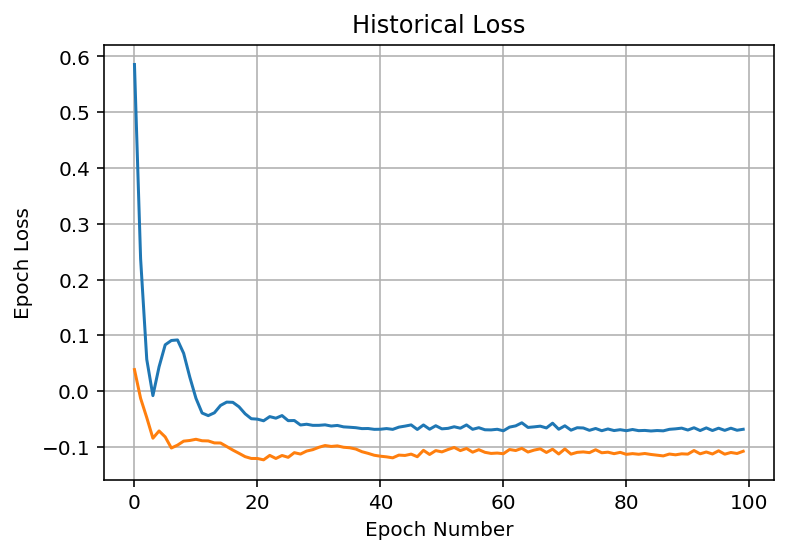

{'target_loss': 0.76151, 'ts': '2020-05-12T19:48:03', 'W_lst[0].shape': (59, 1), 'final_loss': -0.06846696883440018, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
{'msg': 'TargetingModelPipeline.save start', 'ts': '2020-05-12T19:48:03'}
{'msg': 'ModelFlowBase.save start', 'path': '/tmp/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444'}
{'msg': 'DRM_Gradient.save start', 'path': '/tmp/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444_model_e8604319-2e3d-41db-89cc-1ac164c4cd3c'}
{'msg': 'dir not exist, create it', 'path': '/tmp/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444_model_e8604319-2e3d-41db-89cc-1ac164c4cd3c', 'dirname': '/tmp/targeting_flow_045cad9a-3ee1-425d-a70b-751edfd71444'}
{'msg': 'DRM_Gradient.save finish', 'model_info': {'model_type': 'drm_model', 'path': '/tmp/targeting_flow_045

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 517620.00000 517620.00000
mean       7.73413      0.41849
std       22.91758      2.10682
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     1748.28000     46.10000
-0.10670722
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:48:11', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  51763.00000         0.66422   32454.34000         0.00000    84045.00864          0.00000 0.38615
1 103525.00000         0.66423   50474.81000         0.00000   112537.17502          0.00000 0.44852
2 155287.00000         0.66423   65951.27000         0.00000   138376.94779          0.00000 0.47661
3 207049.00000         0.66423   78216.40000         0.00000   154137.14567          0.00000 0.50745
4 258811.00000         0.66423   90682.57000         0.00000   173350.44016       

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 221838.00000 221838.00000
mean       7.76177      0.41817
std       23.73317      2.09125
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     3292.97000     45.43000
-0.10585722
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:48:16', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  22185.00000         0.66437   13765.16000         0.00000    31285.19080          0.00000 0.43999
1  44368.00000         0.66438   21779.22000         0.00000    42662.87638          0.00000 0.51050
2  66552.00000         0.66438   27923.46000         0.00000    54492.29550          0.00000 0.51243
3  88735.00000         0.66438   33395.46000         0.00000    62188.39533          0.00000 0.53700
4 110920.00000         0.66438   38512.63000         0.00000    66553.84650        

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 517620.00000 517620.00000
mean       7.73413      0.41849
std       22.91758      2.10682
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     1748.28000     46.10000
-0.10670722
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:48:24', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  51763.00000         0.66422   32454.34000         0.00000    84045.00864          0.00000 0.38615
1 103525.00000         0.66423   50474.81000         0.00000   112537.17502          0.00000 0.44852
2 155287.00000         0.66423   65951.27000         0.00000   138376.94779          0.00000 0.47661
3 207049.00000         0.66423   78216.40000         0.00000   154137.14567          0.00000 0.50745
4 258811.00000         0.66423   90682.57000         0.00000   173350.44016       

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 221838.00000 221838.00000
mean       7.76177      0.41817
std       23.73317      2.09125
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     3292.97000     45.43000
-0.10585722
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:48:28', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  22185.00000         0.66437   13765.16000         0.00000    31285.19080          0.00000 0.43999
1  44368.00000         0.66438   21779.22000         0.00000    42662.87638          0.00000 0.51050
2  66552.00000         0.66438   27923.46000         0.00000    54492.29550          0.00000 0.51243
3  88735.00000         0.66438   33395.46000         0.00000    62188.39533          0.00000 0.53700
4 110920.00000         0.66438   38512.63000         0.00000    66553.84650        

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


['gb_0d', 'negative_ni_0d', 'cohort']
             gb_0d  negative_ni_0d
count 517620.00000    517620.00000
mean       7.73413        -0.24829
std       22.91758         4.27448
min        0.00000      -457.76000
25%        0.00000        -0.00000
50%        0.00000        -0.00000
75%        0.00000        -0.00000
max     1748.28000       667.60000
-0.10670722
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:48:35', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  51763.00000         0.66422   17362.03891         0.00000    84045.00864          0.00000 0.20658
1 103525.00000         0.66423   29406.42595         0.00000   112537.17502          0.00000 0.26130
2 155287.00000         0.66423   38740.90744         0.00000   138376.94779          0.00000 0.27997
3 207049.00000         0.66423   47682.61197         0.00000   154137.14567          0.00000 0.30935
4 258811.00000   

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


['gb_0d', 'negative_ni_0d', 'cohort']
             gb_0d  negative_ni_0d
count 221838.00000    221838.00000
mean       7.76177        -0.26089
std       23.73317         4.30416
min        0.00000      -478.13000
25%        0.00000        -0.00000
50%        0.00000        -0.00000
75%        0.00000        -0.00000
max     3292.97000       333.62000
-0.10585722
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:48:39', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  22185.00000         0.66437    7392.89636         0.00000    31285.19080          0.00000 0.23631
1  44368.00000         0.66438   12653.83382         0.00000    42662.87638          0.00000 0.29660
2  66552.00000         0.66438   16020.99238         0.00000    54492.29550          0.00000 0.29400
3  88735.00000         0.66438   20731.14950         0.00000    62188.39533          0.00000 0.33336
4 110920.00000    

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


{'msg': 'DRM_gradient.fit start', 'ts': '2020-05-12T19:49:21'}
Epoch 1: with training loss = 0.51
Epoch 10: with training loss = 0.0311
Epoch 20: with training loss = -0.0222
Epoch 30: with training loss = -0.0412
Epoch 40: with training loss = -0.0466
Epoch 50: with training loss = -0.0491
Epoch 60: with training loss = -0.0497
Epoch 70: with training loss = -0.0501
Epoch 80: with training loss = -0.0502
Epoch 90: with training loss = -0.0502
Epoch 100: with training loss = -0.0502
{'msg': 'DRM_gradient.fit', 'target_loss': 0.65939, 'final_loss': -0.05021589994430542, 'ts': '2020-05-12T19:50:16'}


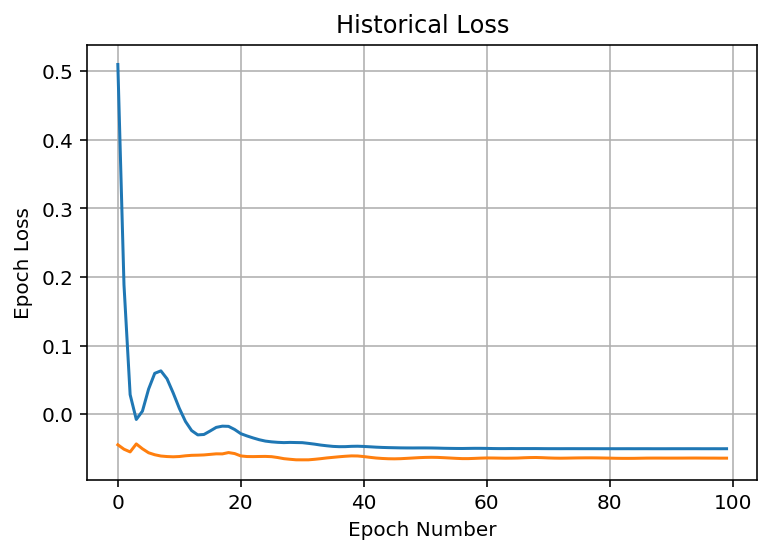

{'target_loss': 0.65939, 'ts': '2020-05-12T19:50:16', 'W_lst[0].shape': (43, 1), 'final_loss': -0.05021589994430542, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
{'msg': 'TargetingModelPipeline.save start', 'ts': '2020-05-12T19:50:16'}
{'msg': 'ModelFlowBase.save start', 'path': '/tmp/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f'}
{'msg': 'DRM_Gradient.save start', 'path': '/tmp/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f_model_2fb0e7d4-89aa-40c8-b44b-0f02d06edbf8'}
{'msg': 'dir not exist, create it', 'path': '/tmp/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f_model_2fb0e7d4-89aa-40c8-b44b-0f02d06edbf8', 'dirname': '/tmp/targeting_flow_e4bac51c-bb17-496b-956a-c8dd0870ba4f'}
{'msg': 'DRM_Gradient.save finish', 'model_info': {'model_type': 'drm_model', 'path': '/tmp/targeting_flow_e4b

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


              gb_0d         spend
count 1046025.00000 1046025.00000
mean        7.46027       0.19045
std        22.49440       1.11118
min         0.00000       0.00000
25%         0.00000       0.00000
50%         0.00000       0.00000
75%         0.00000       0.00000
max      3768.72065      37.60000
0.013339733
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:50:32', 'cost_curve_train.stats':           count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  104604.00000         0.83382    8230.74000         0.00000    32877.26927          0.00002 0.25035
1  209206.00000         0.83382   16517.09000         0.00000    70285.34715          0.00000 0.23500
2  313808.00000         0.83383   24884.42000         0.00000    95238.59443          0.00000 0.26129
3  418411.00000         0.83383   33736.73000         0.00000   121585.92137          0.00000 0.27747
4  523013.00000         0.83383   43483.55000         0.000

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 448297.00000 448297.00000
mean       7.51767      0.19430
std       22.97151      1.11689
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     3723.56000     33.57000
0.012564192
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:50:43', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  44831.00000         0.83395    3537.89000         0.00000    14765.61719          0.00398 0.23960
1  89661.00000         0.83396    7140.63000         0.00000    24083.85209          0.00160 0.29649
2 134489.00000         0.83396   11072.22000         0.00000    36644.96422          0.00012 0.30215
3 179319.00000         0.83397   14940.99000         0.00000    51348.95332          0.00000 0.29097
4 224149.00000         0.83396   19212.66000         0.00000    55123.01346        

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


              gb_0d         spend
count 1046025.00000 1046025.00000
mean        7.46027       0.19045
std        22.49440       1.11118
min         0.00000       0.00000
25%         0.00000       0.00000
50%         0.00000       0.00000
75%         0.00000       0.00000
max      3768.72065      37.60000
0.013339733
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:51:00', 'cost_curve_train.stats':           count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  104604.00000         0.83382    8230.74000         0.00000    32877.26927          0.00002 0.25035
1  209206.00000         0.83382   16517.09000         0.00000    70285.34715          0.00000 0.23500
2  313808.00000         0.83383   24884.42000         0.00000    95238.59443          0.00000 0.26129
3  418411.00000         0.83383   33736.73000         0.00000   121585.92137          0.00000 0.27747
4  523013.00000         0.83383   43483.55000         0.000

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             gb_0d        spend
count 448297.00000 448297.00000
mean       7.51767      0.19430
std       22.97151      1.11689
min        0.00000      0.00000
25%        0.00000      0.00000
50%        0.00000      0.00000
75%        0.00000      0.00000
max     3723.56000     33.57000
0.012564192
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:51:06', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  44831.00000         0.83395    3537.89000         0.00000    14765.61719          0.00398 0.23960
1  89661.00000         0.83396    7140.63000         0.00000    24083.85209          0.00160 0.29649
2 134489.00000         0.83396   11072.22000         0.00000    36644.96422          0.00012 0.30215
3 179319.00000         0.83397   14940.99000         0.00000    51348.95332          0.00000 0.29097
4 224149.00000         0.83396   19212.66000         0.00000    55123.01346        

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


['gb_0d', 'negative_ni_0d', 'cohort']
              gb_0d  negative_ni_0d
count 1046025.00000   1046025.00000
mean        7.46027        -0.42164
std        22.49440         4.16015
min         0.00000      -159.87000
25%         0.00000        -0.00000
50%         0.00000        -0.00000
75%         0.00000        -0.00000
max      3768.72065       381.30000
0.013339733
None
{'msg': 'create_cost_curve_for_train_params finish', 'ts': '2020-05-12T19:51:22', 'cost_curve_train.stats':           count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  104604.00000         0.83382    2416.70499         0.16601    32877.26927          0.00002 0.07351
1  209206.00000         0.83382    2042.40872         0.41208    70285.34715          0.00000 0.02906
2  313808.00000         0.83383    7169.40290         0.01857    95238.59443          0.00000 0.07528
3  418411.00000         0.83383   11752.54877         0.00112   121585.92137          0.00000 0.09666
4  

/Users/ehsan.mousavi/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


['gb_0d', 'negative_ni_0d', 'cohort']
             gb_0d  negative_ni_0d
count 448297.00000    448297.00000
mean       7.51767        -0.42953
std       22.97151         4.30471
min        0.00000      -631.08000
25%        0.00000        -0.00000
50%        0.00000        -0.00000
75%        0.00000        -0.00000
max     3723.56000       433.94000
0.012564192
None
{'msg': 'create_cost_curve_for_test_params finish', 'ts': '2020-05-12T19:51:28', 'cost_curve_train.stats':          count  Treatment Prct  Inc Cost Sum  Inc Cost P-val  Inc Value Sum  Inc Value P-val    CPIV
0  44831.00000         0.83395      75.54850         0.95138    14765.61719          0.00398 0.00512
1  89661.00000         0.83396    1582.04522         0.40608    24083.85209          0.00160 0.06569
2 134489.00000         0.83396    3230.17955         0.14749    36644.96422          0.00012 0.08815
3 179319.00000         0.83397    5329.65345         0.03824    51348.95332          0.00000 0.10379
4 224149.00000    

In [84]:
result_2 = run_DRM(k=1,comment = '')

In [87]:
plot_info(result_2[3]['info'])

IndexError: list index out of range

# Multi Structure

In [24]:
sys.path.append('/Users/ehsan.mousavi/Box/EhsanUber/project/promotion/multi-structure DRM/github/multi-structure-targeting/src/')

from cost_curve import Multi_model

round: 0.0
[35, 4]
Epoch 1: with training loss = 13.9554176331
Epoch 10: with training loss = 3.41655492783
Epoch 20: with training loss = 2.33601331711
Epoch 30: with training loss = 1.62342178822
Epoch 40: with training loss = 1.36984920502
Epoch 50: with training loss = 1.32534682751
Epoch 60: with training loss = 1.11974573135
Epoch 70: with training loss = 1.05959820747
Epoch 80: with training loss = 1.24534416199
Epoch 90: with training loss = 1.21753787994
Epoch 100: with training loss = 1.13487172127
Epoch 110: with training loss = 1.2109156847
Epoch 120: with training loss = 1.32322955132
Epoch 130: with training loss = 1.40223109722
Epoch 140: with training loss = 1.1963738203
Epoch 150: with training loss = 1.22824847698
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 1.2282484769821167}


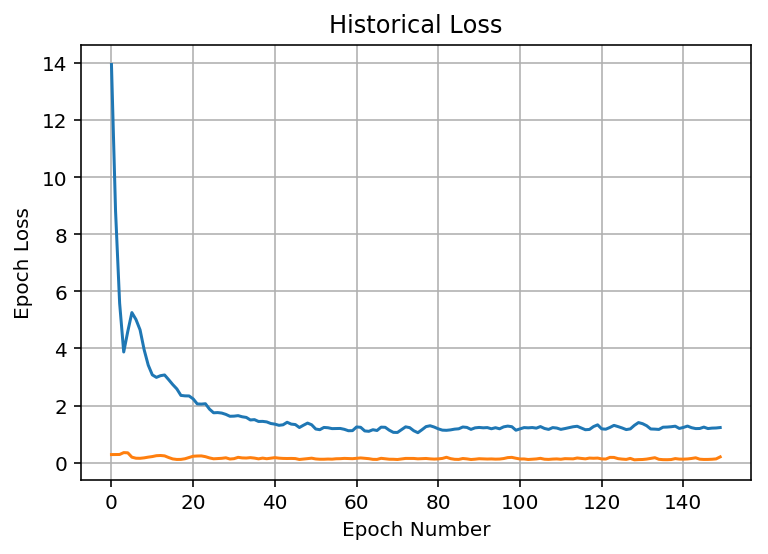

{'target_loss': 300, 'ts': 'May 13 2020 14:06:12', 'W_lst[0].shape': (35, 4), 'final_loss': 1.2282484769821167, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 0.2
[35, 4]
Epoch 1: with training loss = 13.8631792068
Epoch 10: with training loss = 3.1558470726
Epoch 20: with training loss = 2.1010427475
Epoch 30: with training loss = 1.60947299004
Epoch 40: with training loss = 1.27989447117
Epoch 50: with training loss = 1.21274316311
Epoch 60: with training loss = 1.12289142609
Epoch 70: with training loss = 1.20801472664
Epoch 80: with training loss = 1.16782557964
Epoch 90: with training loss = 1.09236061573
Epoch 100: with training loss = 1.08967590332
Epoch 110: with training loss = 1.13874673843
Epoch 120: with training loss = 1.1114025116
Epoch 130: with training loss = 1.08588397503
Epoch 140: with training loss = 1.07760190964
Epoch 150: with training loss = 1.16049742699
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 1.16049742

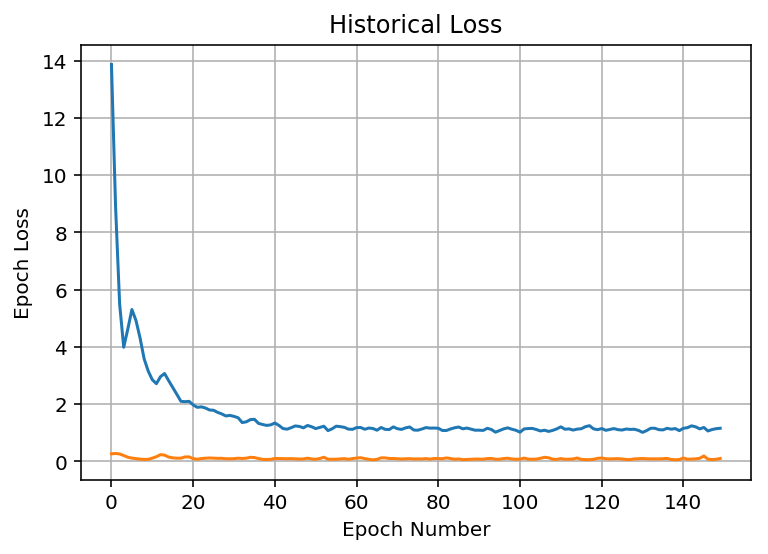

{'target_loss': 300, 'ts': 'May 13 2020 14:08:57', 'W_lst[0].shape': (35, 4), 'final_loss': 1.1604974269866943, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 0.4
[35, 4]
Epoch 1: with training loss = 14.0077362061
Epoch 10: with training loss = 2.96151709557
Epoch 20: with training loss = 2.05391764641
Epoch 30: with training loss = 1.57594871521
Epoch 40: with training loss = 1.3072270155
Epoch 50: with training loss = 1.11198437214
Epoch 60: with training loss = 1.0840357542
Epoch 70: with training loss = 1.13980221748
Epoch 80: with training loss = 1.08294510841
Epoch 90: with training loss = 1.20944273472
Epoch 100: with training loss = 1.16574716568
Epoch 110: with training loss = 1.07269561291
Epoch 120: with training loss = 1.15603983402
Epoch 130: with training loss = 1.02527403831
Epoch 140: with training loss = 1.28969120979
Epoch 150: with training loss = 1.11913347244
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 1.1191334

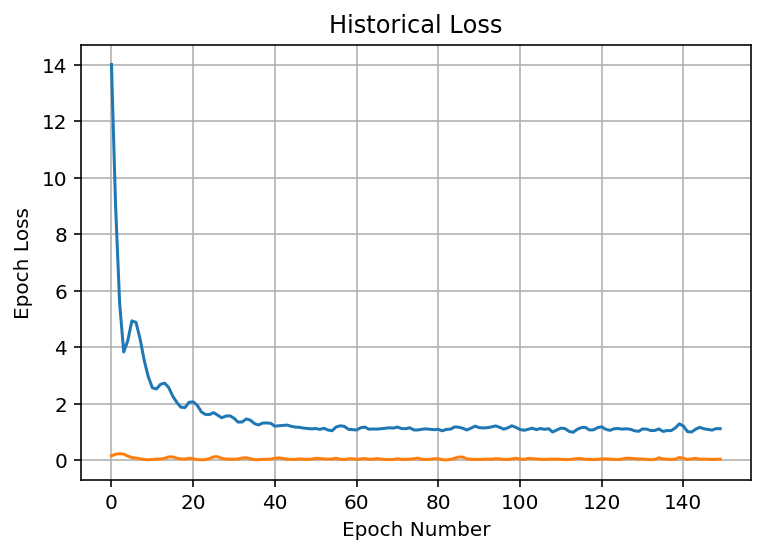

{'target_loss': 300, 'ts': 'May 13 2020 14:11:43', 'W_lst[0].shape': (35, 4), 'final_loss': 1.119133472442627, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 0.6000000000000001
[35, 4]
Epoch 1: with training loss = 14.9586248398
Epoch 10: with training loss = 3.09763050079
Epoch 20: with training loss = 2.0527100563
Epoch 30: with training loss = 1.3908624649
Epoch 40: with training loss = 1.12847197056
Epoch 50: with training loss = 1.10578095913
Epoch 60: with training loss = 0.988198041916
Epoch 70: with training loss = 0.98508900404
Epoch 80: with training loss = 1.11843383312
Epoch 90: with training loss = 1.05324208736
Epoch 100: with training loss = 1.13427710533
Epoch 110: with training loss = 0.970441758633
Epoch 120: with training loss = 1.10295581818
Epoch 130: with training loss = 1.18733990192
Epoch 140: with training loss = 0.921400725842
Epoch 150: with training loss = 1.01810348034
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final

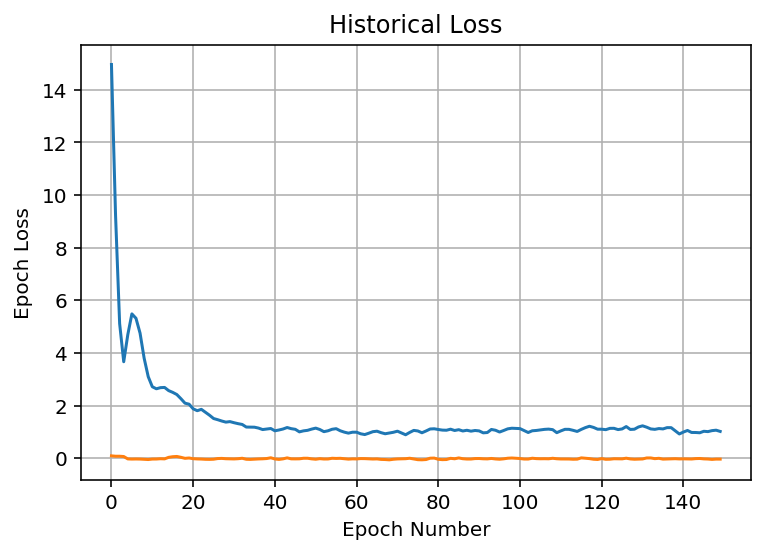

{'target_loss': 300, 'ts': 'May 13 2020 14:14:25', 'W_lst[0].shape': (35, 4), 'final_loss': 1.0181034803390503, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 0.8
[35, 4]
Epoch 1: with training loss = 12.5762348175
Epoch 10: with training loss = 2.81015467644
Epoch 20: with training loss = 1.76607608795
Epoch 30: with training loss = 1.28512895107
Epoch 40: with training loss = 1.17603135109
Epoch 50: with training loss = 1.06646931171
Epoch 60: with training loss = 1.16325759888
Epoch 70: with training loss = 1.1024377346
Epoch 80: with training loss = 1.09042167664
Epoch 90: with training loss = 0.929391264915
Epoch 100: with training loss = 0.947412669659
Epoch 110: with training loss = 0.845579206944
Epoch 120: with training loss = 0.993246495724
Epoch 130: with training loss = 0.934296667576
Epoch 140: with training loss = 0.972905218601
Epoch 150: with training loss = 0.896303355694
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 0

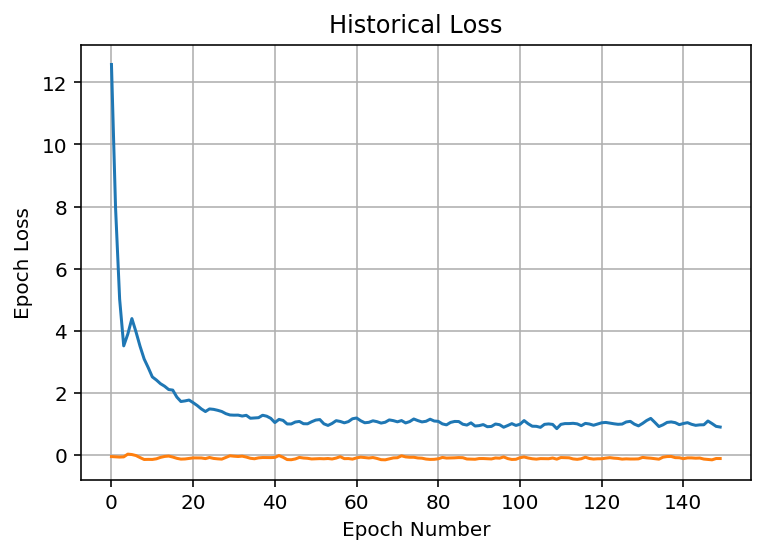

{'target_loss': 300, 'ts': 'May 13 2020 14:17:05', 'W_lst[0].shape': (35, 4), 'final_loss': 0.8963033556938171, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 1.0
[35, 4]
Epoch 1: with training loss = 13.3429431915
Epoch 10: with training loss = 3.02266430855
Epoch 20: with training loss = 1.80937719345
Epoch 30: with training loss = 1.32544946671
Epoch 40: with training loss = 1.03647208214
Epoch 50: with training loss = 0.902343809605
Epoch 60: with training loss = 1.12366700172
Epoch 70: with training loss = 0.999867022038
Epoch 80: with training loss = 0.883047938347
Epoch 90: with training loss = 0.922577559948
Epoch 100: with training loss = 1.03691101074
Epoch 110: with training loss = 0.944476306438
Epoch 120: with training loss = 0.873287200928
Epoch 130: with training loss = 0.892012119293
Epoch 140: with training loss = 0.99594861269
Epoch 150: with training loss = 1.03191828728
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 

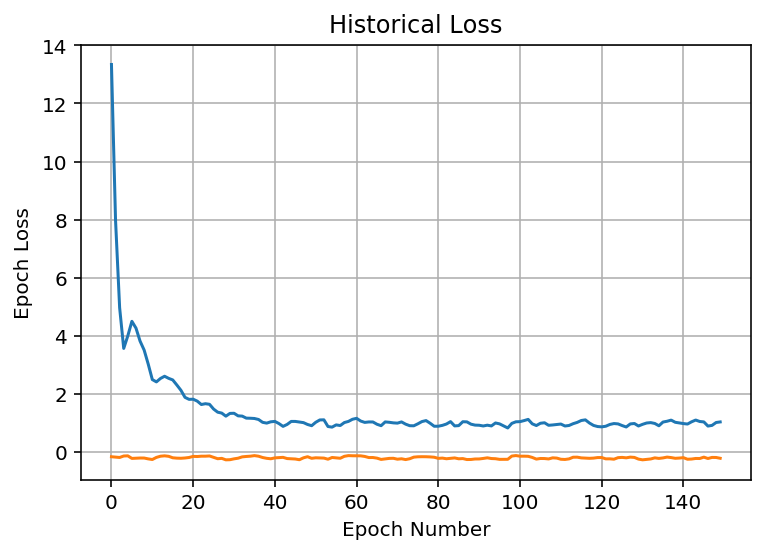

{'target_loss': 300, 'ts': 'May 13 2020 14:19:49', 'W_lst[0].shape': (35, 4), 'final_loss': 1.0319182872772217, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 1.2000000000000002
[35, 4]
Epoch 1: with training loss = 13.4167032242
Epoch 10: with training loss = 2.5427479744
Epoch 20: with training loss = 1.63535809517
Epoch 30: with training loss = 1.13598179817
Epoch 40: with training loss = 0.956895649433
Epoch 50: with training loss = 0.790103137493
Epoch 60: with training loss = 0.832528412342
Epoch 70: with training loss = 0.84352594614
Epoch 80: with training loss = 0.838225245476
Epoch 90: with training loss = 1.00044775009
Epoch 100: with training loss = 0.852847993374
Epoch 110: with training loss = 0.734643518925
Epoch 120: with training loss = 0.833924651146
Epoch 130: with training loss = 0.962583482265
Epoch 140: with training loss = 0.719679176807
Epoch 150: with training loss = 0.80481415987
{'msg': 'DRM_gradient.fit', 'target_loss': 300

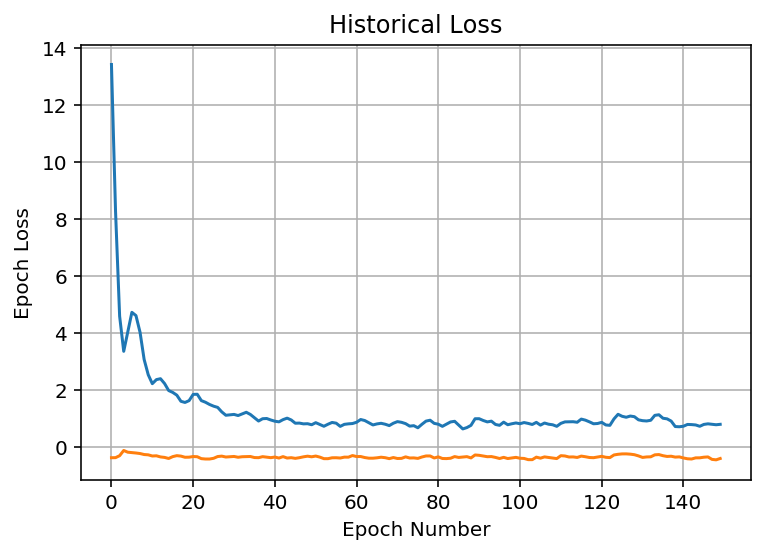

{'target_loss': 300, 'ts': 'May 13 2020 14:22:28', 'W_lst[0].shape': (35, 4), 'final_loss': 0.8048141598701477, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 1.4000000000000001
[35, 4]
Epoch 1: with training loss = 13.4412708282
Epoch 10: with training loss = 2.7293548584
Epoch 20: with training loss = 1.60150945187
Epoch 30: with training loss = 1.12571775913
Epoch 40: with training loss = 1.02371537685
Epoch 50: with training loss = 0.989002525806
Epoch 60: with training loss = 0.952951490879
Epoch 70: with training loss = 0.751713812351
Epoch 80: with training loss = 0.765207111835
Epoch 90: with training loss = 0.82128828764
Epoch 100: with training loss = 0.946009278297
Epoch 110: with training loss = 0.773910105228
Epoch 120: with training loss = 0.748326182365
Epoch 130: with training loss = 1.14410281181
Epoch 140: with training loss = 0.7101328969
Epoch 150: with training loss = 0.742759227753
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 

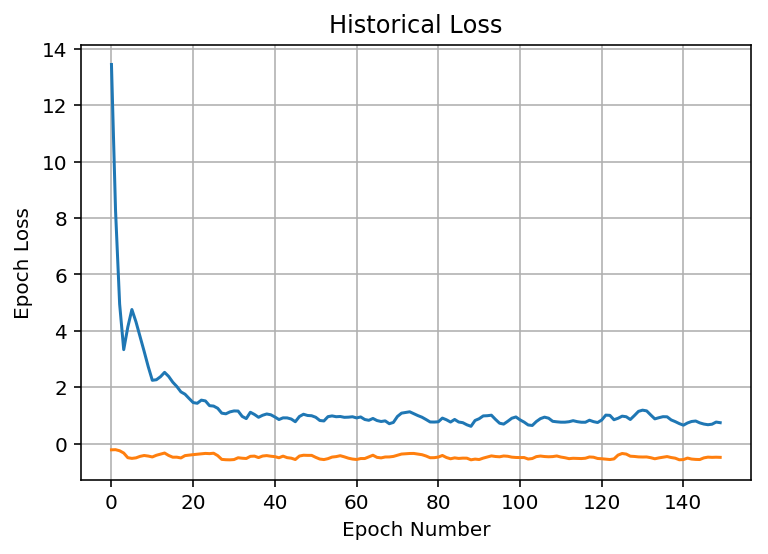

{'target_loss': 300, 'ts': 'May 13 2020 14:25:16', 'W_lst[0].shape': (35, 4), 'final_loss': 0.7427592277526855, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 1.6
[35, 4]
Epoch 1: with training loss = 13.2050590515
Epoch 10: with training loss = 2.45690703392
Epoch 20: with training loss = 1.42799329758
Epoch 30: with training loss = 1.07528412342
Epoch 40: with training loss = 0.764096558094
Epoch 50: with training loss = 0.739606142044
Epoch 60: with training loss = 0.833224117756
Epoch 70: with training loss = 0.702091515064
Epoch 80: with training loss = 0.754765331745
Epoch 90: with training loss = 0.755049824715
Epoch 100: with training loss = 1.18241834641
Epoch 110: with training loss = 0.827319264412
Epoch 120: with training loss = 0.755707383156
Epoch 130: with training loss = 0.733501136303
Epoch 140: with training loss = 0.586429655552
Epoch 150: with training loss = 0.663604795933
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_los

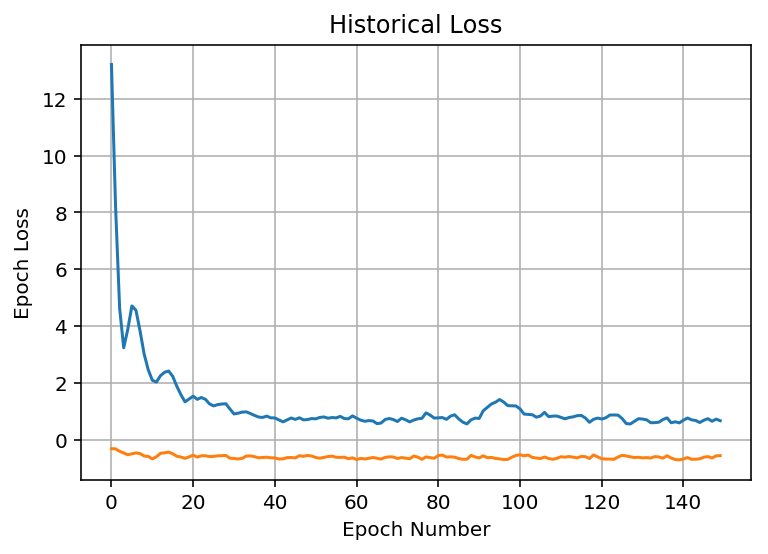

{'target_loss': 300, 'ts': 'May 13 2020 14:28:06', 'W_lst[0].shape': (35, 4), 'final_loss': 0.6636047959327698, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}
round: 1.8
[35, 4]
Epoch 1: with training loss = 13.76313591
Epoch 10: with training loss = 2.46590328217
Epoch 20: with training loss = 2.20636034012
Epoch 30: with training loss = 1.14154267311
Epoch 40: with training loss = 0.828458249569
Epoch 50: with training loss = 0.732758402824
Epoch 60: with training loss = 0.633320629597
Epoch 70: with training loss = 0.555695354939
Epoch 80: with training loss = 0.605133593082
Epoch 90: with training loss = 0.553264796734
Epoch 100: with training loss = 0.69642239809
Epoch 110: with training loss = 0.956572473049
Epoch 120: with training loss = 0.750834405422
Epoch 130: with training loss = 0.64499104023
Epoch 140: with training loss = 0.3323366642
Epoch 150: with training loss = 0.439988076687
{'msg': 'DRM_gradient.fit', 'target_loss': 300, 'final_loss': 0

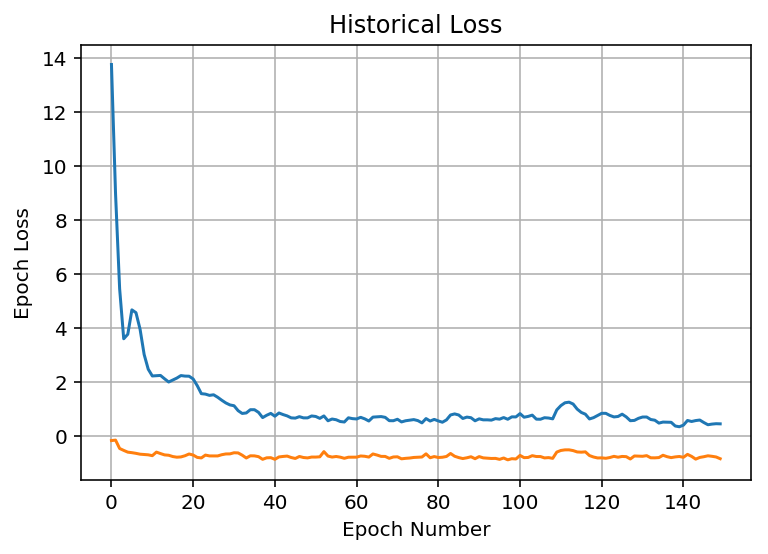

{'target_loss': 300, 'ts': 'May 13 2020 14:30:57', 'W_lst[0].shape': (35, 4), 'final_loss': 0.43998807668685913, 'msg': 'DRM_gradient.fit finish', 'W_lst[0].type': <type 'numpy.ndarray'>}


In [128]:
model_paramters = {"number_structures" : 4, 
                                "target_loss" : 300, 
                                "verbose" : True,
                                "dim_hidden_lst": [],
                                "obj_rule" : 'lagrangian',
                                "shadow" : 0.4,
                                "lambda_saving":.4,
                                "epochs" :  150,
                                "reg_scale" :.5,
                                "reg_type" :"L1",
                                "standardization_input" : True,
                  "dim_hidden_lst" :[]}
    
train, test = train_test_split(APR,test_size= .3)
dataset = {'train': train, 'test': test}
avg_score = []
metric = []
for l in np.arange(0,2,.2):
    print('========'*4)
    print('round: '+str(l))
    model_paramters['shadow'] = l
    model = Multi_model(dataset,**model_paramters)
    score, mt = model.run()
    metric.append(mt) 
    avg_score.append(score.mean().to_dict())


In [121]:
def cross_entropy(x):
    return np.sum(-x*np.log(x))
pd.DataFrame(avg_score).apply(cross_entropy,axis=1)

0   1.36686
1   1.37154
2   1.36183
3   1.36572
4   1.30102
5   1.37005
6   1.37943
7   1.37320
8   1.36745
9   1.38519
dtype: float64

In [137]:
metric

[{'cpigb': 0.27919595011876397,
  'gb_0d': 0.32204399075190704,
  'ni_0d': -0.08991337797801713,
  'ni_cost': 0.08991337797801713,
  'saving': 0.03890421832274568,
  'spend': 0.14545187738127602},
 {'cpigb': 0.2515481155556147,
  'gb_0d': 0.264225761927265,
  'ni_0d': -0.06646549249404998,
  'ni_cost': 0.06646549249404998,
  'saving': 0.03922481227685602,
  'spend': 0.10303536669754779},
 {'cpigb': 0.32452598503713,
  'gb_0d': 0.42373765600928426,
  'ni_0d': -0.1375138802137375,
  'ni_cost': 0.1375138802137375,
  'saving': 0.0319811821899762,
  'spend': 0.20315315566775705},
 {'cpigb': 0.29990365301681726,
  'gb_0d': 0.44687131863744245,
  'ni_0d': -0.13401834088781112,
  'ni_cost': 0.13401834088781112,
  'saving': 0.044730186567165875,
  'spend': 0.21322544969189544},
 {'cpigb': 0.35471123116143694,
  'gb_0d': 0.3859237772438018,
  'ni_0d': -0.13689149816062107,
  'ni_cost': 0.13689149816062107,
  'saving': 0.01747801273689964,
  'spend': 0.21111467664676029},
 {'cpigb': 0.37745772963

,Enjoy 10% off $35 or more,Enjoy 20% off $30 or more,Enjoy 20% off $40 or more,control
0,0.16947,0.28244,0.26299,0.28478
1,0.25898,0.30139,0.18410,0.25551
2,0.18818,0.21695,0.33700,0.25771
3,0.16635,0.27075,0.28126,0.28145
4,0.16876,0.42821,0.16159,0.24127
5,0.17667,0.27845,0.25915,0.28542
6,0.28240,0.24791,0.20478,0.26478
7,0.24865,0.31205,0.19857,0.24051
8,0.23945,0.29302,0.17688,0.29044
9,0.24265,0.24554,0.24181,0.26988


,cpigb,gb_0d,ni_0d,ni_cost,saving,spend
0,0.32097,0.30315,-0.09730,0.09730,0.02396,0.16334
1,0.34249,0.33544,-0.11489,0.11489,0.01929,0.18419
2,0.33077,0.30621,-0.10128,0.10128,0.02120,0.17257
3,0.25633,0.33577,-0.08607,0.08607,0.04824,0.16825
4,0.30389,0.35607,-0.10821,0.10821,0.03422,0.18715
5,0.31294,0.27480,-0.08600,0.08600,0.02392,0.13851
6,0.39930,0.38696,-0.15451,0.15451,0.00027,0.23151
7,0.27214,0.36835,-0.10024,0.10024,0.04710,0.18452
8,0.31567,0.30448,-0.09611,0.09611,0.02568,0.16738
9,0.30833,0.40392,-0.12454,0.12454,0.03703,0.21871


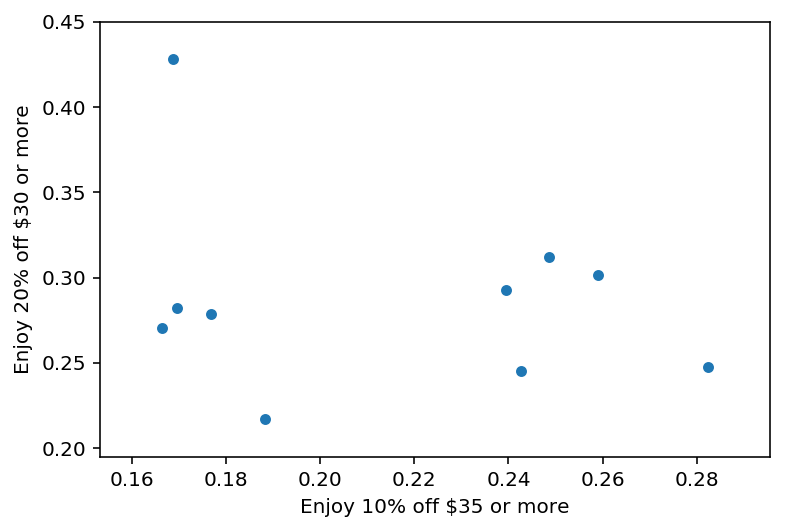

In [123]:
display(pd.DataFrame(avg_score))
display(pd.DataFrame(metric))

pd.DataFrame(avg_score).plot.scatter(x= 'Enjoy 10% off $35 or more', y ='Enjoy 20% off $30 or more')

In [83]:
display(pd.DataFrame([(x[0].to_dict()) for x,l in zip(avg_score,np.arange(0,5))]))
metric['saving_spend']=metric.spend+metric
pd.DataFrame(metric)

,Enjoy 10% off $35 or more,Enjoy 20% off $30 or more,Enjoy 20% off $40 or more,control
0,0.19964,0.30592,0.21153,0.28248
1,0.22224,0.24756,0.25698,0.27274
2,0.14668,0.26659,0.26554,0.32081
3,0.21823,0.21408,0.26675,0.30043
4,0.30714,0.16474,0.18226,0.34544


,cpigb,gb_0d,ni_0d,ni_cost,saving,spend
0,0.35514,0.32563,-0.11564,0.11564,0.01461,0.18548
1,0.28937,0.32462,-0.09394,0.09394,0.03591,0.15393
2,0.36401,0.22658,-0.08248,0.08248,0.00815,0.12464
3,0.29044,0.27755,-0.08061,0.08061,0.03041,0.14335
4,0.46194,0.30339,-0.14015,0.14015,-0.01879,0.22541


In [74]:
[add_d(x[0].to_dict() ,{'lambda':l}) for x,l in zip(avg_score,np.arange(0,1.5,.1))]
#[['Enjoy 20% off $40 or more','control']].plot(marker='o')


[{'Enjoy 10% off $35 or more': 0.2668726444244385,
  'Enjoy 20% off $30 or more': 0.22500397264957428,
  'Enjoy 20% off $40 or more': 0.22352969646453857,
  'control': 0.28440189361572266,
  'lambda': 0.0},
 {'Enjoy 10% off $35 or more': 0.22424177825450897,
  'Enjoy 20% off $30 or more': 0.20573391020298004,
  'Enjoy 20% off $40 or more': 0.24660982191562653,
  'control': 0.3230436146259308,
  'lambda': 0.1},
 {'Enjoy 10% off $35 or more': 0.2290675789117813,
  'Enjoy 20% off $30 or more': 0.2887883186340332,
  'Enjoy 20% off $40 or more': 0.20016899704933167,
  'control': 0.2818066477775574,
  'lambda': 0.2},
 {'Enjoy 10% off $35 or more': 0.18098753690719604,
  'Enjoy 20% off $30 or more': 0.25055626034736633,
  'Enjoy 20% off $40 or more': 0.255543053150177,
  'control': 0.31244969367980957,
  'lambda': 0.30000000000000004},
 {'Enjoy 10% off $35 or more': 0.22888605296611786,
  'Enjoy 20% off $30 or more': 0.2870709002017975,
  'Enjoy 20% off $40 or more': 0.21213717758655548,
  'c

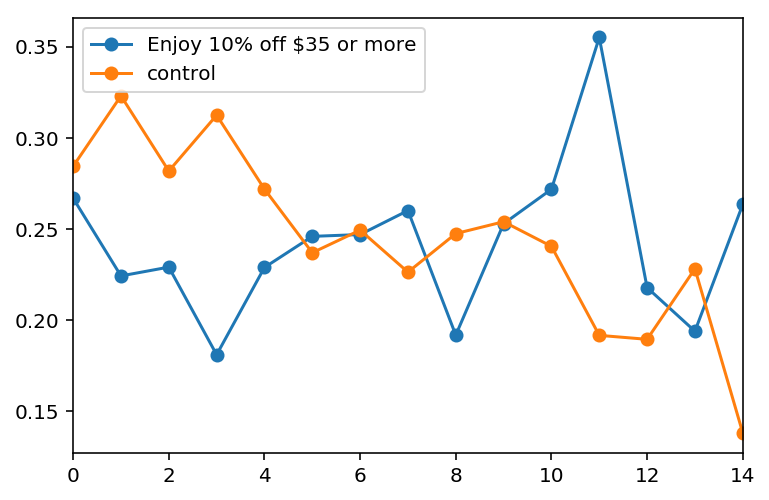

In [58]:
pd.DataFrame([x[0].to_dict() for x in avg_score])[['Enjoy 10% off $35 or more','control']].plot(marker='o')


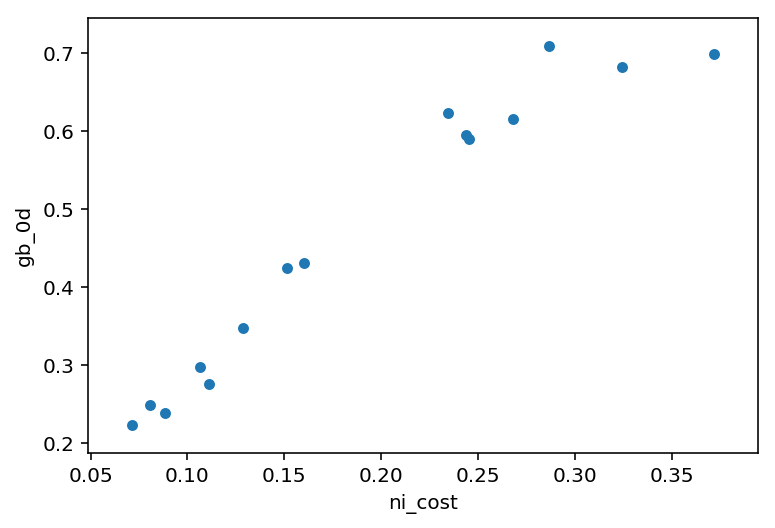

In [39]:
pd.DataFrame(metric).plot.scatter(y='gb_0d', x= "ni_cost")

In [75]:
metric

[{'cpigb': 0.37196155109540535,
  'gb_0d': 0.2378236140801091,
  'ni_0d': -0.08846124038035247,
  'ni_cost': 0.08846124038035247,
  'saving': 0.07801528947572389,
  'spend': 0.14241640737841035},
 {'cpigb': 0.3191185892495736,
  'gb_0d': 0.22322495711483814,
  'ni_0d': -0.07123523339978372,
  'ni_cost': 0.07123523339978372,
  'saving': 0.08502223658060298,
  'spend': 0.11788553258806532},
 {'cpigb': 0.40224131765182136,
  'gb_0d': 0.2757763868160641,
  'ni_0d': -0.11092865721015199,
  'ni_cost': 0.11092865721015199,
  'saving': 0.08211481356109285,
  'spend': 0.17281998039195698},
 {'cpigb': 0.32438872387501233,
  'gb_0d': 0.2492090272562386,
  'ni_0d': -0.08084059832978441,
  'ni_cost': 0.08084059832978441,
  'saving': 0.09360572074958262,
  'spend': 0.13582152265269143},
 {'cpigb': 0.35709997257148535,
  'gb_0d': 0.297920146624886,
  'ni_0d': -0.10638727618823968,
  'ni_cost': 0.10638727618823968,
  'saving': 0.1021568264491805,
  'spend': 0.16691424305643202},
 {'cpigb': 0.356854690

In [149]:
np.arange(0,1.5,.1)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4])

In [30]:
pd.DataFrame(metric)

,cpigb,gb_0d,ni_0d,ni_cost,saving,spend
0,0.29405,0.58497,-0.17201,0.17201,0.23747,0.31620
1,0.46506,0.14399,-0.06696,0.06696,0.03383,0.10356
2,0.55517,0.14301,-0.07939,0.07939,0.02071,0.12319
3,0.38255,0.69017,-0.26402,0.26402,0.21910,0.42429
4,0.40969,0.75546,-0.30951,0.30951,0.21932,0.47601


In [33]:
print('comment: DNN +CPIV')
print(avg_score)
pd.DataFrame(metric)

comment: DNN +CPIV
[[Enjoy 10% off $35 or more   0.02416
Enjoy 20% off $30 or more   0.03587
Enjoy 20% off $40 or more   0.62694
control                     0.31422
dtype: float32], [Enjoy 10% off $35 or more   0.04127
Enjoy 20% off $30 or more   0.03295
Enjoy 20% off $40 or more   0.16270
control                     0.76352
dtype: float32], [Enjoy 10% off $35 or more   0.32162
Enjoy 20% off $30 or more   0.04176
Enjoy 20% off $40 or more   0.04831
control                     0.58842
dtype: float32], [Enjoy 10% off $35 or more   0.11338
Enjoy 20% off $30 or more   0.07489
Enjoy 20% off $40 or more   0.78058
control                     0.03154
dtype: float32], [Enjoy 10% off $35 or more   0.22892
Enjoy 20% off $30 or more   0.47887
Enjoy 20% off $40 or more   0.24953
control                     0.04219
dtype: float32]]


,cpigb,gb_0d,ni_0d,ni_cost,saving,spend
0,0.29405,0.58497,-0.17201,0.17201,0.23747,0.31620
1,0.46506,0.14399,-0.06696,0.06696,0.03383,0.10356
2,0.55517,0.14301,-0.07939,0.07939,0.02071,0.12319
3,0.38255,0.69017,-0.26402,0.26402,0.21910,0.42429
4,0.40969,0.75546,-0.30951,0.30951,0.21932,0.47601


In [151]:
avg_score

[[Enjoy 10% off $35 or more   0.20765
  Enjoy 20% off $30 or more   0.33037
  Enjoy 20% off $40 or more   0.16815
  control                     0.29344
  dtype: float32], [Enjoy 10% off $35 or more   0.25461
  Enjoy 20% off $30 or more   0.21688
  Enjoy 20% off $40 or more   0.22083
  control                     0.30742
  dtype: float32], [Enjoy 10% off $35 or more   0.25912
  Enjoy 20% off $30 or more   0.19944
  Enjoy 20% off $40 or more   0.26265
  control                     0.27857
  dtype: float32], [Enjoy 10% off $35 or more   0.32792
  Enjoy 20% off $30 or more   0.20664
  Enjoy 20% off $40 or more   0.19895
  control                     0.26637
  dtype: float32], [Enjoy 10% off $35 or more   0.24022
  Enjoy 20% off $30 or more   0.26993
  Enjoy 20% off $40 or more   0.24932
  control                     0.24033
  dtype: float32], [Enjoy 10% off $35 or more   0.22734
  Enjoy 20% off $30 or more   0.29106
  Enjoy 20% off $40 or more   0.21598
  control                     0.2654

In [158]:
rr_m = pd.DataFrame(metric)
rr_m['cost'] = -rr_m["ni_0d"]

In [200]:
rr_d= result_2[0]['info'][('Mixed', '')]['cost_ni']['test']["stats"][['CPIV','Inc Cost per User'	,'Inc Value per User']]

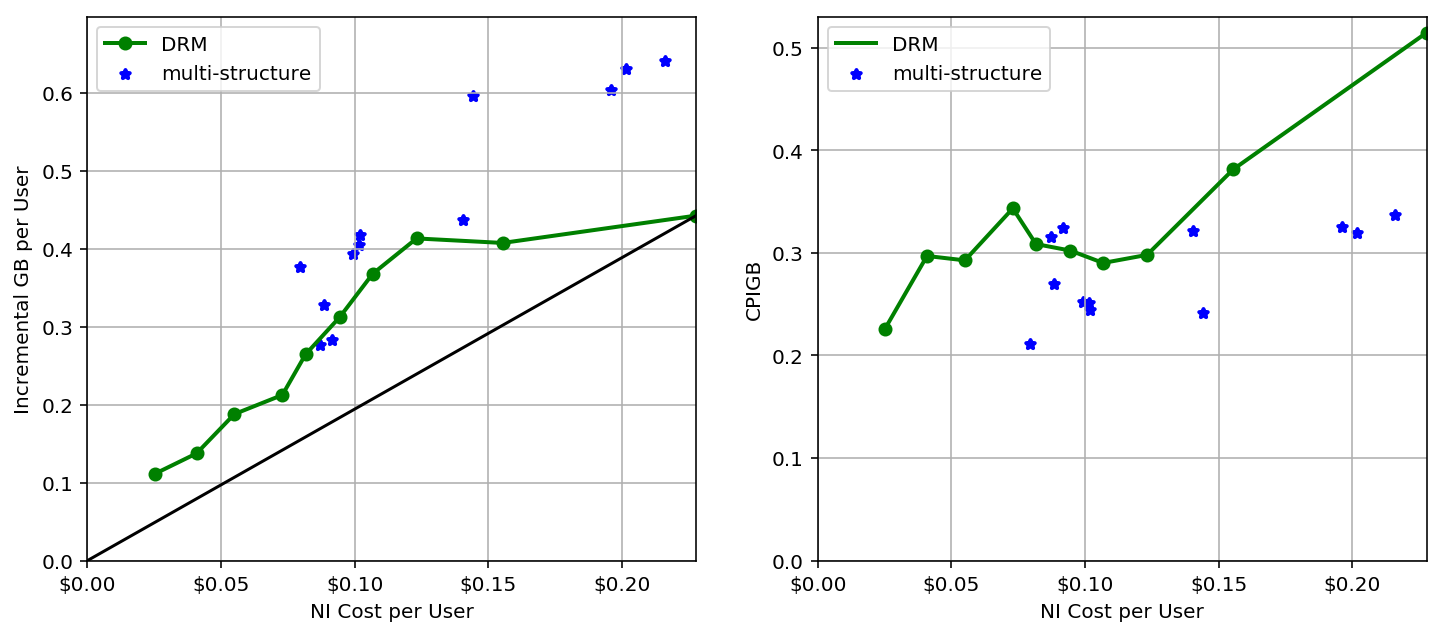

In [207]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
rr_d.plot(x ='Inc Cost per User'	,
            y ='Inc Value per User', 
             grid=True, title='' , ax=ax1, linewidth=2, color='green', label = 'DRM',marker= 'o')

rr_m.plot.scatter(x ='cost'	,
            y ='gb_0d', 
             grid=True, title='' , ax=ax1, linewidth=2, color='blue', label = 'multi-structure',marker= '*')


xx = [0, rr_d.tail(1)['Inc Cost per User'].values[0]]
yy = [0, rr_d.tail(1)['Inc Value per User'].values[0]]
ax1.plot(xx,yy, color='black')
ax1.set_ylabel('Incremental GB per User')
ax1.get_legend()
formatter = ticker.FormatStrFormatter('$%1.2f')
ax1.xaxis.set_major_formatter(formatter)
ax1.set_xlabel('NI Cost per User')
ax1.legend().set_visible(True)

rr_d.plot(x ='Inc Cost per User'	,y ='CPIV'	, 
             grid=True, title='' , ax=ax2, linewidth=2, color='green', label = 'DRM',marker= 'o')

rr_m.plot.scatter(x ='cost'	,y ='cpigb', 
             grid=True, title='' , ax=ax2, linewidth=2, color='blue', label = 'multi-structure',marker= '*')



ax2.set_ylabel('CPIGB')
ax2.set_xlabel('NI Cost per User')
ax2.xaxis.set_major_formatter(formatter)



ax1.set_ylim(ymin=0)
ax1.set_xlim(xmin=0)
ax2.set_ylim(ymin=0)
ax2.set_xlim(xmin=0)



plt.show()



In [152]:
[x[0].to_dict() for x in avg_score]
#pd.DataFrame(avg_score)

[{'Enjoy 10% off $35 or more': 0.20765410363674164,
  'Enjoy 20% off $30 or more': 0.3303689956665039,
  'Enjoy 20% off $40 or more': 0.16815486550331116,
  'control': 0.2934386432170868},
 {'Enjoy 10% off $35 or more': 0.2546064853668213,
  'Enjoy 20% off $30 or more': 0.21688149869441986,
  'Enjoy 20% off $40 or more': 0.22083315253257751,
  'control': 0.3074162006378174},
 {'Enjoy 10% off $35 or more': 0.2591155469417572,
  'Enjoy 20% off $30 or more': 0.19943901896476746,
  'Enjoy 20% off $40 or more': 0.2626497447490692,
  'control': 0.2785692811012268},
 {'Enjoy 10% off $35 or more': 0.3279176950454712,
  'Enjoy 20% off $30 or more': 0.2066413164138794,
  'Enjoy 20% off $40 or more': 0.19894632697105408,
  'control': 0.26637256145477295},
 {'Enjoy 10% off $35 or more': 0.2402227222919464,
  'Enjoy 20% off $30 or more': 0.26993176341056824,
  'Enjoy 20% off $40 or more': 0.24932155013084412,
  'control': 0.24033476412296295},
 {'Enjoy 10% off $35 or more': 0.22733868658542633,
  '

In [140]:
result_multi = [{'comment': 'h = tf.nn.softmax(20*tf.nn.tanh(h))',
               'metric': metric,
                 'avg_score':avg_score},
               {'comment': 'bach Normalziation',
               'metric': metric,
                 'avg_score':avg_score}
               ] 

In [141]:
result_multi

[{'avg_score': [[Enjoy 10% off $35 or more   0.00165
    Enjoy 20% off $30 or more   0.00031
    Enjoy 20% off $40 or more   0.88745
    control                     0.11148
    dtype: float32], [Enjoy 10% off $35 or more   0.01321
    Enjoy 20% off $30 or more   0.00022
    Enjoy 20% off $40 or more   0.86837
    control                     0.11878
    dtype: float32], [Enjoy 10% off $35 or more   0.00067
    Enjoy 20% off $30 or more   0.00103
    Enjoy 20% off $40 or more   0.91082
    control                     0.08868
    dtype: float32], [Enjoy 10% off $35 or more   0.00293
    Enjoy 20% off $30 or more   0.00026
    Enjoy 20% off $40 or more   0.91453
    control                     0.08324
    dtype: float32], [Enjoy 10% off $35 or more   0.00172
    Enjoy 20% off $30 or more   0.00021
    Enjoy 20% off $40 or more   0.92895
    control                     0.07037
    dtype: float32], [Enjoy 10% off $35 or more   0.00020
    Enjoy 20% off $30 or more   0.00019
    Enjoy 20% off

In [58]:
msr = [{'Enjoy 10% off $35 or more': 0.20765410363674164,
  'Enjoy 20% off $30 or more': 0.3303689956665039,
  'Enjoy 20% off $40 or more': 0.16815486550331116,
  'control': 0.2934386432170868},
 {'Enjoy 10% off $35 or more': 0.2546064853668213,
  'Enjoy 20% off $30 or more': 0.21688149869441986,
  'Enjoy 20% off $40 or more': 0.22083315253257751,
  'control': 0.3074162006378174},
 {'Enjoy 10% off $35 or more': 0.2591155469417572,
  'Enjoy 20% off $30 or more': 0.19943901896476746,
  'Enjoy 20% off $40 or more': 0.2626497447490692,
  'control': 0.2785692811012268},
 {'Enjoy 10% off $35 or more': 0.3279176950454712,
  'Enjoy 20% off $30 or more': 0.2066413164138794,
  'Enjoy 20% off $40 or more': 0.19894632697105408,
  'control': 0.26637256145477295},
 {'Enjoy 10% off $35 or more': 0.2402227222919464,
  'Enjoy 20% off $30 or more': 0.26993176341056824,
  'Enjoy 20% off $40 or more': 0.24932155013084412,
  'control': 0.24033476412296295},
 {'Enjoy 10% off $35 or more': 0.22733868658542633,
  'Enjoy 20% off $30 or more': 0.2910587787628174,
  'Enjoy 20% off $40 or more': 0.21598415076732635,
  'control': 0.26543107628822327},
 {'Enjoy 10% off $35 or more': 0.22556228935718536,
  'Enjoy 20% off $30 or more': 0.2670731246471405,
  'Enjoy 20% off $40 or more': 0.21785038709640503,
  'control': 0.28923365473747253},
 {'Enjoy 10% off $35 or more': 0.34029489755630493,
  'Enjoy 20% off $30 or more': 0.21296259760856628,
  'Enjoy 20% off $40 or more': 0.22171398997306824,
  'control': 0.224764883518219},
 {'Enjoy 10% off $35 or more': 0.1382625252008438,
  'Enjoy 20% off $30 or more': 0.44103941321372986,
  'Enjoy 20% off $40 or more': 0.21847456693649292,
  'control': 0.20196576416492462},
 {'Enjoy 10% off $35 or more': 0.19040091335773468,
  'Enjoy 20% off $30 or more': 0.24391163885593414,
  'Enjoy 20% off $40 or more': 0.2711890637874603,
  'control': 0.29433581233024597},
 {'Enjoy 10% off $35 or more': 0.24059037864208221,
  'Enjoy 20% off $30 or more': 0.24078670144081116,
  'Enjoy 20% off $40 or more': 0.21911589801311493,
  'control': 0.29913565516471863},
 {'Enjoy 10% off $35 or more': 0.31646692752838135,
  'Enjoy 20% off $30 or more': 0.2533104121685028,
  'Enjoy 20% off $40 or more': 0.21968209743499756,
  'control': 0.21035024523735046},
 {'Enjoy 10% off $35 or more': 0.24794234335422516,
  'Enjoy 20% off $30 or more': 0.23219364881515503,
  'Enjoy 20% off $40 or more': 0.2939136028289795,
  'control': 0.22559797763824463},
 {'Enjoy 10% off $35 or more': 0.22737422585487366,
  'Enjoy 20% off $30 or more': 0.29007047414779663,
  'Enjoy 20% off $40 or more': 0.19413816928863525,
  'control': 0.2881641089916229},
 {'Enjoy 10% off $35 or more': 0.2226199209690094,
  'Enjoy 20% off $30 or more': 0.2329234629869461,
  'Enjoy 20% off $40 or more': 0.3126467168331146,
  'control': 0.23155440390110016}]

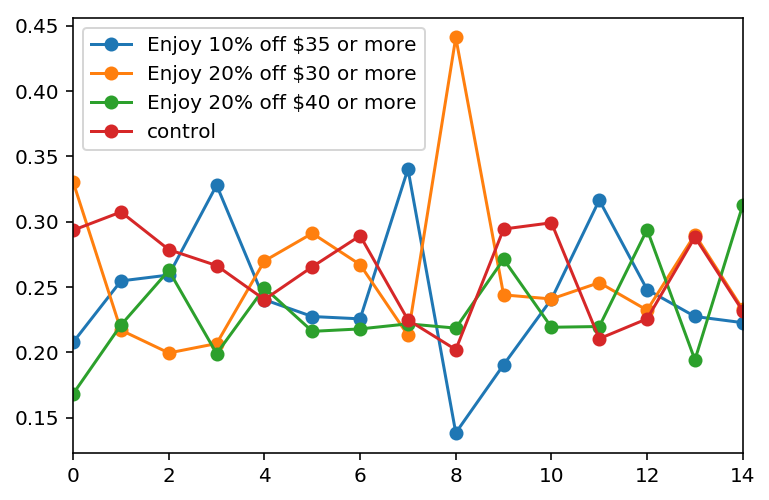

In [63]:
pd.DataFrame(msr).plot(marker = 'o')